# Clustering evaluation on high dimensional data

Here, we explore how the higher dimensional simplices are preserved within parts of a partition. We compare the number of simplices preserved in the ground truth partition with the number preserved via Leiden.

Surprisingly, although Leiden generally yields a larger partition size - so a finer partition - than the ground truth partition, it tends to preserve a larger number of simplices. This implies that Leiden's result is not a refinement of the ground truth: it groups points differently and preserves more of the simplices structure than the ground truth.

Moreover, the Leiden partition (obtained on the kNN in high dimension) also preserves more of the low-dimensional simplices than the ground-truth partition does.

In [9]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [2]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn import cluster
from IPython.display import display, Markdown, Latex

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

import networkx as nx
import igraph as ig
import leidenalg as la
import cdlib.algorithms as cd
import itertools
import collections
import scipy

from community import community_louvain

sns.set()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [3]:
## Assigns a ground_truth part to each clustering_labels part, or none. 
## It assigns whatever ground_truth part intersects with at least 50% of the clustering_labels part.
def mapping_partitions(ground_truth, clustering_labels):
    partition_mapping = []
    cl_max = np.max(clustering_labels)
    gt_max = np.max(ground_truth)
    for j in range(gt_max+1):
        for i in range(cl_max+1):       
            cl_indicator = (clustering_labels==i)
            gt_indicator = (ground_truth==j)
            if(sum(cl_indicator&gt_indicator) > 0.5*min(sum(cl_indicator), sum(gt_indicator))):
                partition_mapping.append((j,i))
    return(pd.DataFrame(partition_mapping, columns=['ground_truth', 'cluster']))

## Counts how many cliques of G of sizes 1,...,x are preserved within parts of the clustering_labels partition.
def clique_per_cluster(G, clustering_labels, x):
    cliques_part = []
    for d in range(np.max(clustering_labels)+1):
        sg = G.subgraph([i for i in range(G.vcount()) if clustering_labels[i]==d])
        cliques_part.append([len(sg.cliques(min=k,max=k)) for k in range(1, x+1)])
    res = pd.DataFrame(cliques_part, columns=[f'{str(i)}-clique' for i in range(1, x+1)])
    return(res)

def clique_preservation(G, ground_truth, clustering_labels, max_clique = 5):
    # Clique stats
    gt_stats = clique_per_cluster(G, ground_truth, x=max_clique)
    gt_summary = gt_stats.sum().reset_index(name='Count').rename(columns={'index': 'Structure'})
    gt_summary['Preserved in'] = 'Ground Truth'
    
    cl_stats = clique_per_cluster(G, clustering_labels, x=max_clique)
    cl_summary = cl_stats.sum().reset_index(name='Count').rename(columns={'index': 'Structure'})
    cl_summary['Preserved in'] = 'Leiden'
    
    all_summary = gt_summary.copy()
    all_summary['Count'] = [len(G.cliques(min=k,max=k)) for k in range(1, 5+1)]
    all_summary['Preserved in'] = 'All'
    all_summary['Structure'] = gt_summary.Structure
    
    clique_summary = pd.concat([all_summary, gt_summary, cl_summary])
    
    # Cluster mapping stats
    part_map = mapping_partitions(ground_truth, clustering_labels)
    clique_per_part = part_map.merge(cl_stats, left_on='cluster', right_index=True).merge(gt_stats, left_on='ground_truth', right_index=True, suffixes=('_cl', '_gt'))

    return(clique_per_part, clique_summary)  

In [4]:
# raw_data, targets, dataset_name = get_dataset(dataset_id)
# display(Markdown(f'## {dataset_name}'))
# G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
# G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
# umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2)

# ec = la.find_partition(G, la.ModularityVertexPartition)
# clustering_labels = np.array(ec.membership)
# G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

# ## q-based clustering
# if(verbose):
#     print('Ground truth: ')
#     print('size = ', max(targets)+1)
#     print('q = ',G.modularity(targets))
#     print('Leiden partition: ')
#     print('size = ', max(clustering_labels)+1)
#     print('q =',G.modularity(ec))
#     print('-----------------------')
#     print('ari =',adjusted_rand_score(targets,clustering_labels))
#     print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

# clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
# agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
# agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
# present_gt = np.isin(clustering_labels, list(agree_cl_gt.ground_truth))
# disagreement_labels = (agree_cl&present_gt)

# Pendigits - fuzzy union

In [5]:
dataset_id = 0
set_op_mix_ratio = 1
raw_data, targets, dataset_name = get_dataset(dataset_id)
display(Markdown(f'## {dataset_name}'))
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2, return_vectors=False)

## pendigits

In [6]:
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

In [7]:
## q-based clustering
print('Ground truth: ')
print('size = ', max(targets)+1)
print('q = ',G.modularity(targets))
print('Leiden partition: ')
print('size = ', max(clustering_labels)+1)
print('q =',G.modularity(ec))
print('-----------------------')
print('ari =',adjusted_rand_score(targets,clustering_labels))
print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

Ground truth: 
size =  10
q =  0.8424726535927892
Leiden partition: 
size =  12
q = 0.8601756688450055
-----------------------
ari = 0.882723265824925
ami = 0.9031742261305846


In [8]:
clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
present_gt = np.isin(clustering_labels, list(agree_cl_gt.ground_truth))
disagreement_labels = (agree_cl&present_gt)

### Run the same analysis on all other datasets

In [9]:
def what_we_do_here(dataset_id, set_op_mix_ratio, verbose=True):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data, n_components=2, return_vectors=False)
    
    ec = la.find_partition(G, la.ModularityVertexPartition)
    clustering_labels = np.array(ec.membership)
    G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')
    
    ## q-based clustering
    if(verbose):
        print('Ground truth: ')
        print('size = ', max(targets)+1)
        print('q = ',G.modularity(targets))
        print('Leiden partition: ')
        print('size = ', max(clustering_labels)+1)
        print('q =',G.modularity(ec))
        print('-----------------------')
        print('ari =',adjusted_rand_score(targets,clustering_labels))
        print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

    clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
    agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
    agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
    present_gt = np.isin(clustering_labels, list(agree_cl_gt.ground_truth))
    disagreement_labels = (agree_cl&present_gt)
    return(G, umap_rep, clique_per_part, clique_summary,disagreement_labels)

# Cliques in fuzzy union graph

## pendigits

Ground truth: 
size =  10
q =  0.8424726535927892
Leiden partition: 
size =  12
q = 0.8599312002698313
-----------------------
ari = 0.8926895057326466
ami = 0.9116173499601601


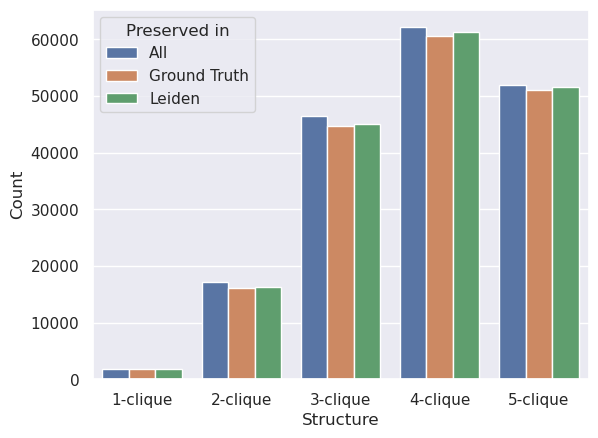

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        5          178         1796         4818         5532   
1              1        9          104          971         3191         5474   
2              1       10           80          652         2061         3590   
3              1       11           27          220          869         2011   
4              2        7          170         1513         4098         5605   
5              3        1          184         1651         4239         5009   
6              4        4          178         1628         4866         7352   
7              5        2          181         1636         4431         5655   
8              6        3          181         1687         4688         6244   
9              7        0          196         1811         5170         7384   
10             8        6          171         1415         3355         3646   
11             9        8          147         1331         3344         3709   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0          3331          178         1796         4818         5532   
1          5917          182         1619         5336         9483   
2          4034          182         1619         5336         9483   
3          3034          182         1619         5336         9483   
4          4839          177         1552         4197         5749   
5          3461          183         1628         4193         4974   
6          6644          181         1632         4868         7350   
7          4217          182         1626         4393         5614   
8          4999          181         1682         4673         6228   
9          6573          179         1674         4883         7057   
10         2303          174         1406         3316         3595   
11         2280          180         1521         3938         4956   

    5-clique_gt  
0          3331  
1         10834  
2         10834  
3         10834  
4          4963  
5          3446  
6          6643  
7          4207  
8          4992  
9          6319  
10         2266  
11         4071

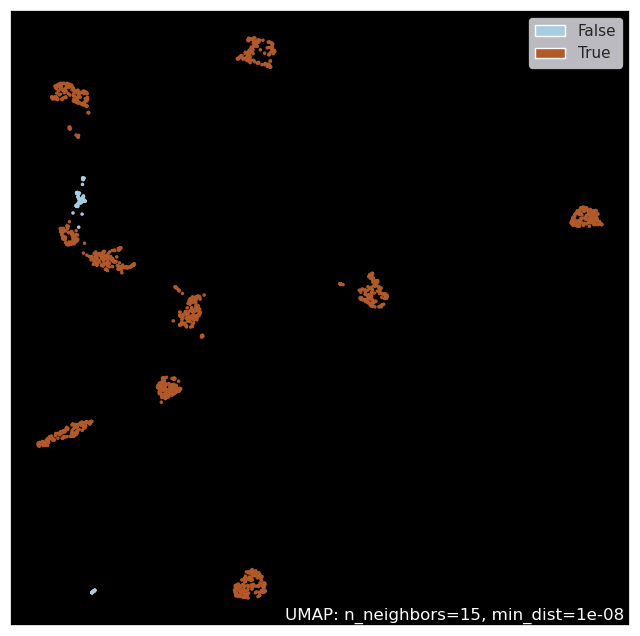

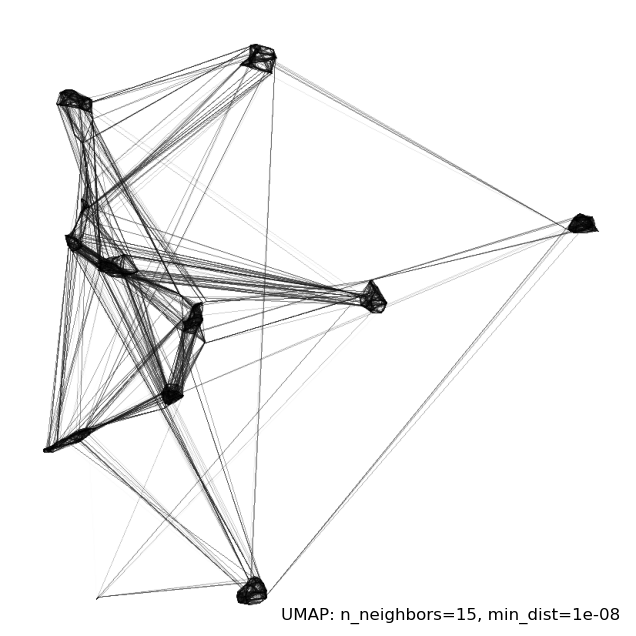

## coil

Ground truth: 
size =  21
q =  0.8945446658779549
Leiden partition: 
size =  27
q = 0.932735066293371
-----------------------
ari = 0.7505439221510641
ami = 0.8797072203271231


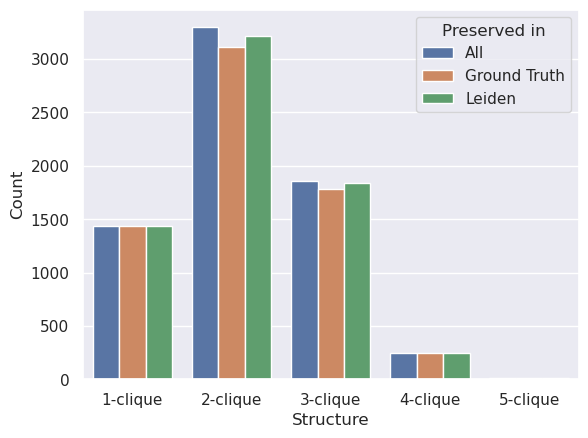

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        4           72          149           85            8   
1              2        2           73          160           95           11   
2              2       21           28           60           40            7   
3              3       25           18           36           22            3   
4              4        3           72          148           80            4   
5              5       14           54          113           51            1   
6              7        0           88          187           95            8   
7              8       18           43           88           46            2   
8              9       19           36           83           46            3   
9              9       23           26           60           36            3   
10            10        5           72          145           74            1   
11            11       10           72          157           72            1   
12            12        9           72          178          119           20   
13            13       15           47          102           66           12   
14            13       24           25           54           39           11   
15            14        6           72          163           63            3   
16            15       17           43           95           64           13   
17            15       20           29           68           44            7   
18            16        8           72          178          129           25   
19            17       16           44          106           85           27   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             0           72          149           85            8   
1             0           72          154           95           13   
2             0           72          154           95           13   
3             0           72          128           58            3   
4             0           72          148           80            4   
5             0           72          143           53            1   
6             0           72          151           86            7   
7             0           72          150           82            7   
8             0           72          166           90            7   
9             0           72          166           90            7   
10            0           72          145           74            1   
11            0           72          157           72            1   
12            0           72          178          119           20   
13            1           72          156          105           23   
14            2           72          156          105           23   
15            0           72          163           63            3   
16            1           72          166          109           20   
17            0           72          166          109           20   
18            0           72          178          129           25   
19            3           72          174          134           40   

    5-clique_gt  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11            0  
12            0  
13            3  
14            3  
15            0  
16            1  
17            1  
18            0  
19            4

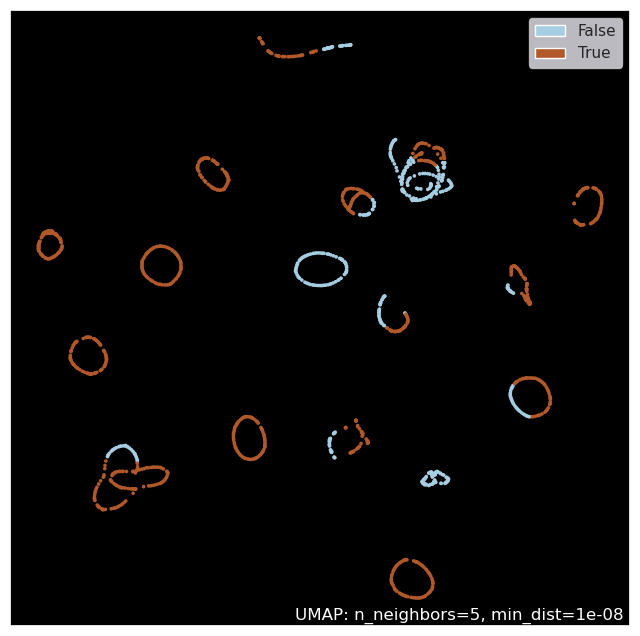

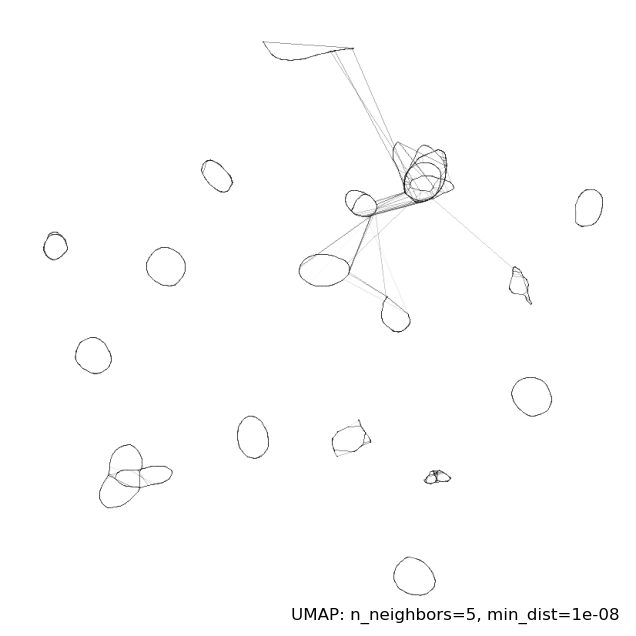

## mnist

Ground truth: 
size =  10
q =  0.828038492552303
Leiden partition: 
size =  13
q = 0.8588806270867967
-----------------------
ari = 0.8243242989740093
ami = 0.8509932161885361


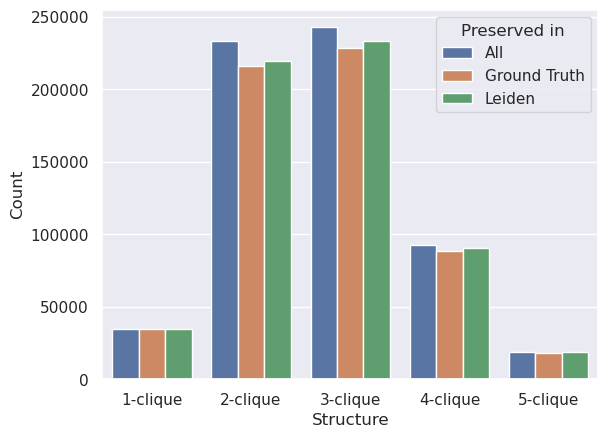

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        3         3494        22943        25764        10451   
1              1        7         2259        14613        19892        11329   
2              1       10         1957        12520        17747        10575   
3              2        4         3305        20294        19454         6340   
4              3        2         3538        22613        21647         6779   
5              4        5         3267        20243        20476         6997   
6              5        8         2117        12567        11593         3422   
7              5       12         1108         6761         7252         2734   
8              6        1         3547        22625        23519         8469   
9              7        0         3645        23523        25941        10126   
10             8        6         3075        19084        17543         5159   
11             9        9         2026        12131        12440         4564   
12             9       11         1662         9891        10029         3668   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0          2029         3434        22422        25247        10284   
1          3603         4002        25997        36408        21313   
2          3297         4002        25997        36408        21313   
3          1007         3434        20370        19324         6279   
4           923         3576        22202        21191         6667   
5          1119         3410        20619        20586         6975   
6           449         3150        19167        18525         5887   
7           499         3150        19167        18525         5887   
8          1497         3465        21901        22766         8206   
9          1837         3632        22871        25121         9807   
10          742         3373        19624        17692         5154   
11          797         3524        21292        21923         8075   
12          663         3524        21292        21923         8075   

    5-clique_gt  
0          2008  
1          6749  
2          6749  
3          1009  
4           913  
5          1106  
6           805  
7           805  
8          1441  
9          1805  
10          744  
11         1432  
12         1432

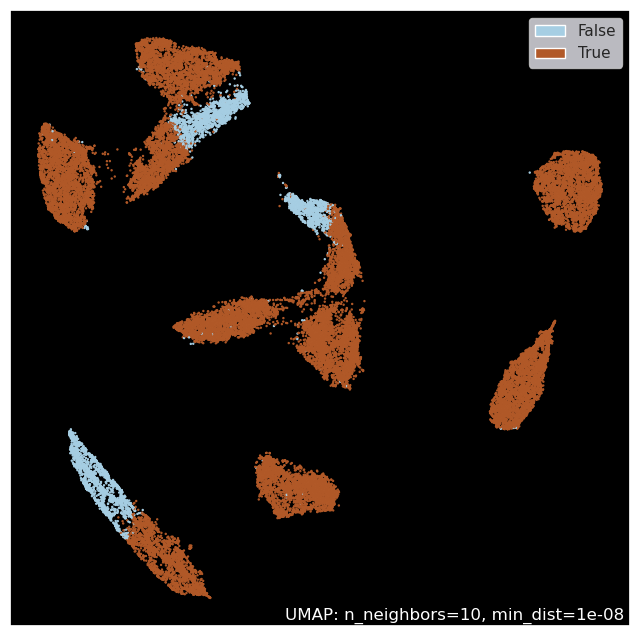

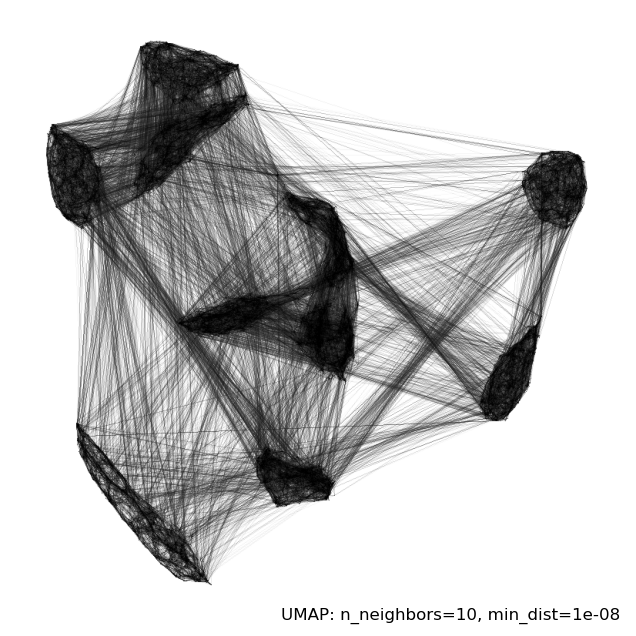

## usps

Ground truth: 
size =  11
q =  0.8283499377845813
Leiden partition: 
size =  12
q = 0.8617428914452613
-----------------------
ari = 0.7921192760296037
ami = 0.8654695954880943


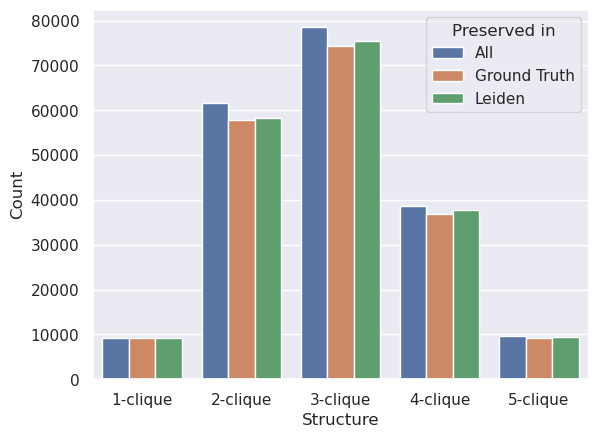

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        2          858         5444         7327         3816   
1              1        7          723         4547         5843         2701   
2              2       10          652         4177         5986         3369   
3              2       11          630         4029         6148         4034   
4              3        0          907         5526         6610         3028   
5              4        3          849         5412         6071         2308   
6              5        5          823         5068         6487         3231   
7              6        9          660         3910         4646         2062   
8              7        4          836         5293         6985         3489   
9              8        6          796         4973         6514         3311   
10             9        8          697         4350         5236         2251   
11            10        1          867         5593         7659         4095   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0           983         1553        10184        13440         6587   
1           517         1553        10184        13440         6587   
2           962         1269         8383        12404         7495   
3          1416         1269         8383        12404         7495   
4           711          929         5483         6458         2909   
5           395          824         5126         5734         2191   
6           852          852         5021         6338         3114   
7           467          716         4060         4698         2033   
8           812          834         5191         6848         3428   
9           857          792         4795         6241         3168   
10          461          708         4284         5132         2205   
11         1080          821         5204         7124         3839   

    5-clique_gt  
0          1506  
1          1506  
2          2379  
3          2379  
4           670  
5           378  
6           804  
7           457  
8           798  
9           827  
10          453  
11         1036

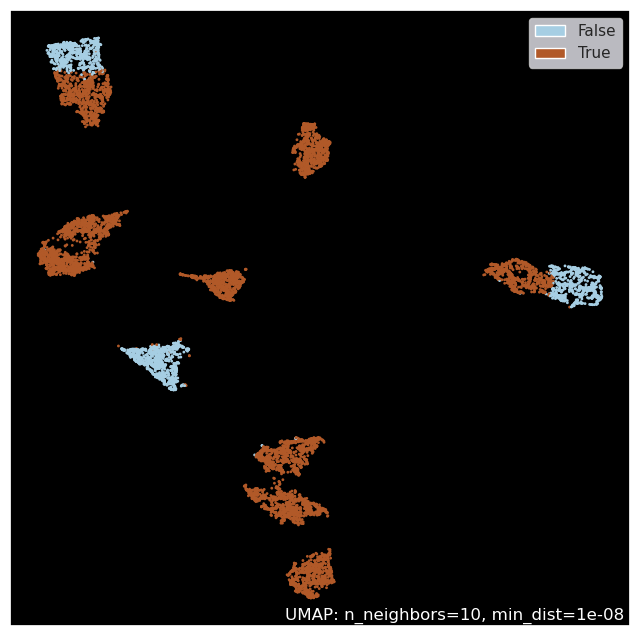

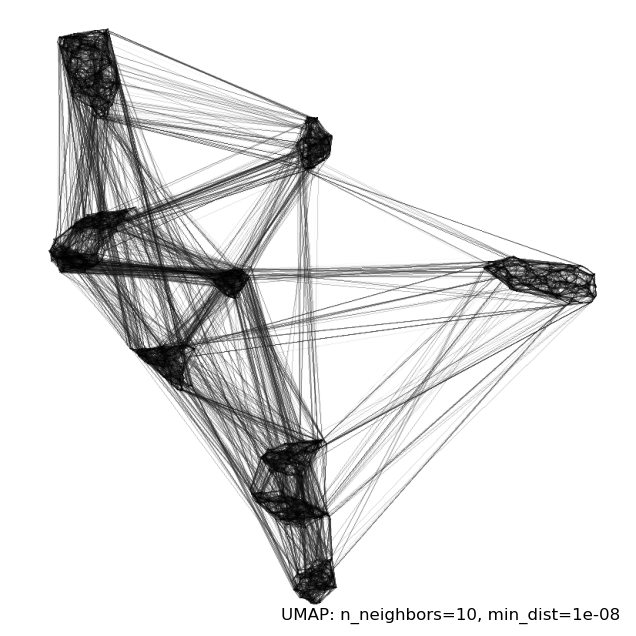

## buildings

Ground truth: 
size =  41
q =  0.7278299373437985
Leiden partition: 
size =  57
q = 0.8981623332790699
-----------------------
ari = 0.2757397955167985
ami = 0.6053878844578454


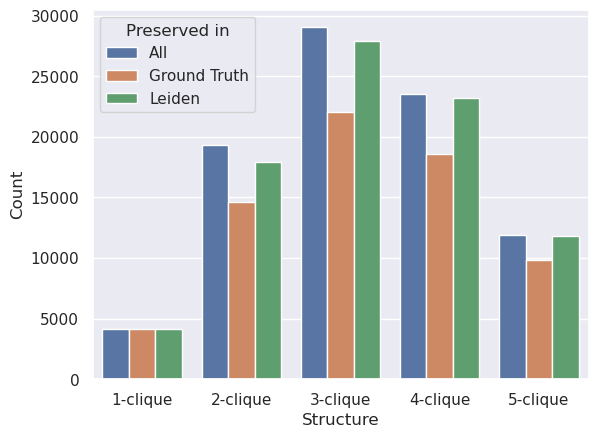

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        7          126          550          729          404   
1              1        8          126          525          613          282   
2              1       26           65          251          405          346   
3              2       19           81          358          608          579   
4              2       46           26          116          231          252   
5              2       52           20           83          169          202   
45            34       19           81          358          608          579   
6              3       37           34          138          238          230   
7              3       42           28          120          173          113   
8              4       34           41          175          296          270   
9              4       45           27          114          213          217   
10             5       30           51          193          289          230   
11             5       44           28          107          180          170   
12             7       20           78          349          594          545   
13             7       41           28          118          220          228   
14             8       24           67          276          426          327   
15             9       29           52          223          395          390   
16             9       51           21           88          142          121   
17             9       55           15           62          126          151   
18            10       32           48          198          343          324   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0            89          334         1239         1626          988   
1            64          334         1239         1626          988   
2           168          334         1239         1626          988   
3           351          112          488          944         1017   
4           161          112          488          944         1017   
5           146          112          488          944         1017   
45          351           35          145          228          206   
6           141          124          462          703          538   
7            45          124          462          703          538   
8           142           70          291          509          487   
9           130           70          291          509          487   
10          112          135          452          660          542   
11          102          135          452          660          542   
12          275          100          415          722          696   
13          146          100          415          722          696   
14          134          104          359          503          361   
15          237          100          396          676          665   
16           61          100          396          676          665   
17          115          100          396          676          665   
18          179          134          471          843          857   

    5-clique_gt  
0           340  
1           340  
2           340  
3           652  
4           652  
5           652  
45          130  
6           240  
7           240  
8           272  
9           272  
10          278  
11          278  
12          390  
13          390  
14          140  
15          413  
16          413  
17          413  
18          529

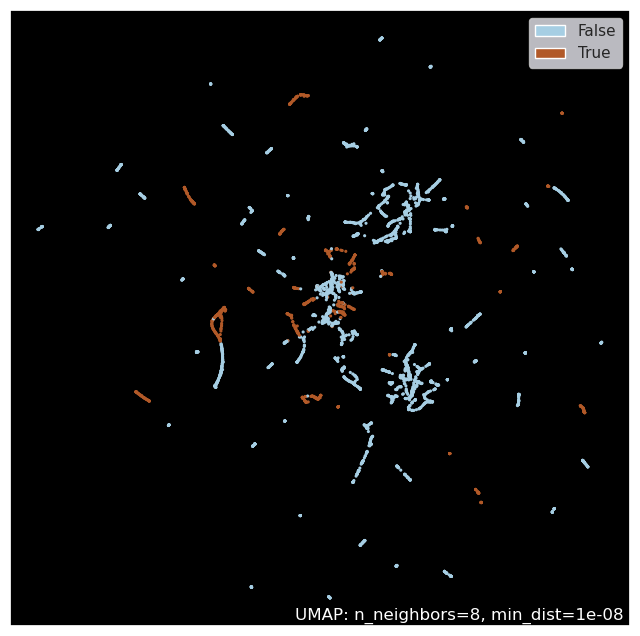

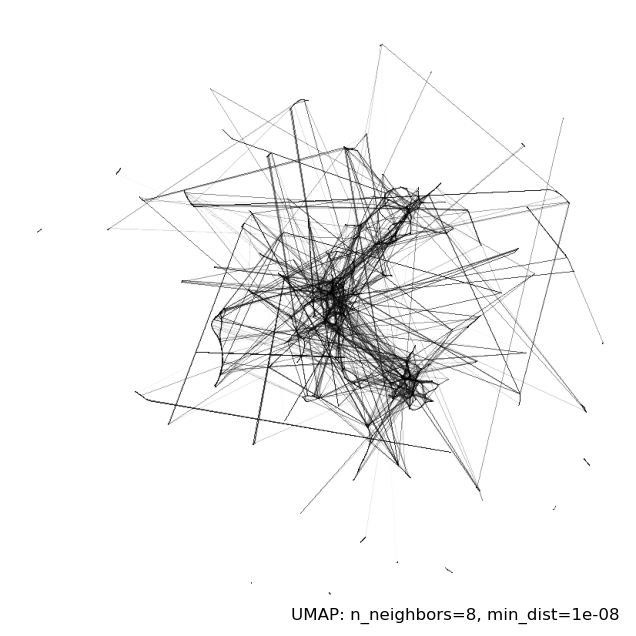

In [12]:
for dataset_id in [0,1,2,3,4]:
    G, umap_rep, clique_per_part, clique_summary, disagreement_labels = what_we_do_here(dataset_id, 1.0)
    sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
    plt.show()
    display(clique_per_part[:20])
    umap.plot.points(umap_rep, labels=disagreement_labels, color_key_cmap='Paired', background='black')
    plt.show()
    umap.plot.connectivity(umap_rep, labels=disagreement_labels, color_key_cmap='Paired')
    plt.show()

# Cliques in fuzzy intersection graph

In [42]:
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
for e in G.es:
    e["leiden_internal"] = (clustering_labels[e.target] == clustering_labels[e.source])

Ground truth: 
size =  21
q =  0.9494420801380001
Leiden partition: 
size =  49
q = 0.9579996944622434
-----------------------
ari = 0.7413482882183544
ami = 0.89578049953426


ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1       12           38           72           35            0   
1              1       17           34           64           31            0   
2              2       27           26           41           16            0   
3              2       30           25           44           21            1   
4              2       33           21           30           10            0   
5              3       14           36           54           19            0   
6              3       15           36           54           19            0   
7              4        6           49           94           46            0   
8              4       32           23           43           21            0   
9              5        0           72          122           38            0   
10             6        5           67           90           22            0   
11             6       42            2            1            0            0   
12             6       43            2            1            0            0   
13             6       48            1            0            0            0   
14             7       13           37           69           33            0   
15             7       16           35           65           31            0   
16             8        9           41           78           39            1   
17             8       23           31           57           27            0   
18             9       10           40           62           10            0   
19             9       20           32           50           12            0   
20            10        1           72          143           71            0   
21            11        4           72          131           47            0   
22            12        8           42           66           19            0   
23            12       24           29           43           15            0   
24            12       44            1            0            0            0   
25            13       25           29           52           24            0   
26            13       29           25           46           22            0   
27            13       34           18           33           16            0   
28            14        3           72          125           25            1   
29            15       18           34           55           22            1   
30            15       22           31           56           28            2   
31            15       39            6           10            7            2   
32            15       45            1            0            0            0   
33            16       26           28           41           13            0   
34            16       28           26           42           17            0   
35            16       35           17           26           11            1   
36            16       46            1            0            0            0   
37            17        7           42           69           29            3   
38            17       36           16           25           12            2   
39            17       38            9           14            7            1   
40            17       41            4            6            4            1   
41            17       47            1            0            0            0   
42            18       21           32           47           17            1   
43            18       31           24           38           14            0   
44            18       37           11           16            7            1   
45            18       40            5            8            5            1   
46            19        2           72          128           45            0   
47            20       11           38           67           29            0   
48            20       19          

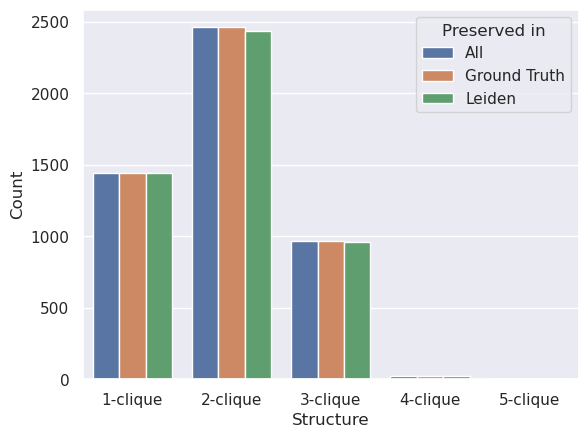

In [43]:
## q-based clustering
print('Ground truth: ')
print('size = ', max(targets)+1)
print('q = ',G.modularity(targets))
print('Leiden partition: ')
print('size = ', max(clustering_labels)+1)
print('q =',G.modularity(ec))
print('-----------------------')
print('ari =',adjusted_rand_score(targets,clustering_labels))
print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
clique_per_part

## Show disagreements

<AxesSubplot:>

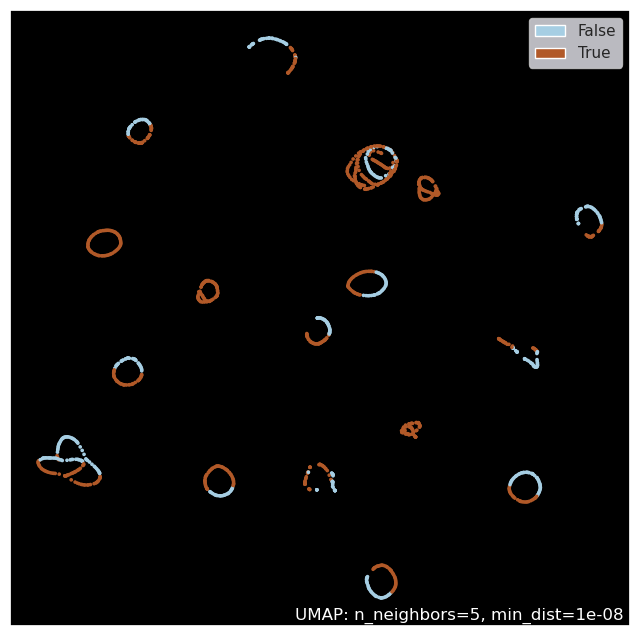

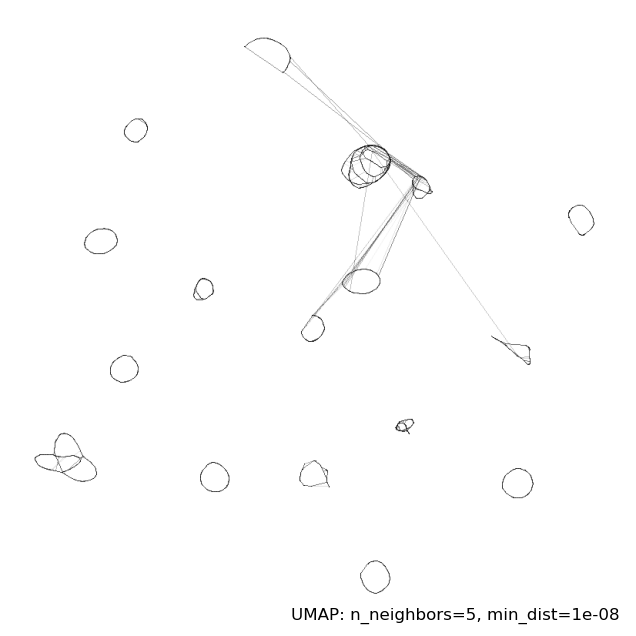

In [44]:
agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
present_gt = np.isin(targets, list(agree_cl_gt.ground_truth))
umap_rep = umap.UMAP(n_neighbors=5, n_components=2, min_dist=1e-8, random_state=0, n_epochs=1000).fit(raw_data)
umap.plot.points(umap_rep, labels=(agree_cl&present_gt), color_key_cmap='Paired', background='black')
umap.plot.connectivity(umap_rep, labels=(agree_cl&present_gt), color_key_cmap='Paired')

## pendigits

Ground truth: 
size =  10
q =  0.8797145712759515
Leiden partition: 
size =  27
q = 0.895541956249761
-----------------------
ari = 0.8517460969160207
ami = 0.8893509910441437


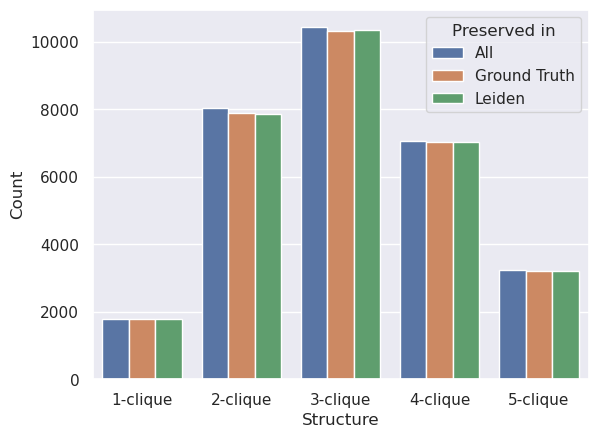

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        3          175          689          663          276   
1              0       17            2            1            0            0   
2              0       26            1            0            0            0   
3              1        9           87          375          527          385   
4              1       10           70          323          537          461   
5              1       13           28          143          322          406   
6              1       22            1            0            0            0   
7              2        5          166          801         1134          834   
8              2       15           10           31           53           56   
9              3        6          156          684          800          400   
10             3       18            1            0            0            0   
11             4        7          145          673          955          648   
12             4       12           29          120          197          173   
13             4       25            1            0            0            0   
14             5        1          178          825         1039          610   
15             6        2          178          820         1025          577   
16             6       16            2            1            0            0   
17             6       23            1            0            0            0   
18             7        4          166          738          948          626   
19             8        0          185          757          905          550   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0            52          178          690          663          276   
1             0          178          690          663          276   
2             0          178          690          663          276   
3           168          182          839         1381         1250   
4           228          182          839         1381         1250   
5           315          182          839         1381         1250   
6             0          182          839         1381         1250   
7           421          177          840         1195          894   
8            36          177          840         1195          894   
9            95          183          773          911          479   
10            0          183          773          911          479   
11          264          181          820         1174          828   
12           85          181          820         1174          828   
13            0          181          820         1174          828   
14          191          182          830         1043          611   
15          188          181          820         1023          576   
16            0          181          820         1023          576   
17            0          181          820         1023          576   
18          249          179          794         1063          775   
19          194          174          711          872          543   

    5-clique_gt  
0            52  
1            52  
2            52  
3           711  
4           711  
5           711  
6           711  
7           458  
8           458  
9           124  
10          124  
11          350  
12          350  
13          350  
14          191  
15          188  
16          188  
17          188  
18          371  
19          193

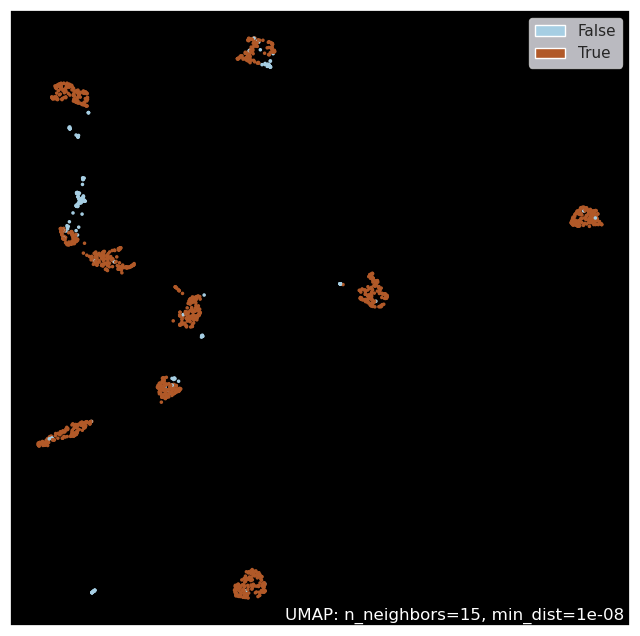

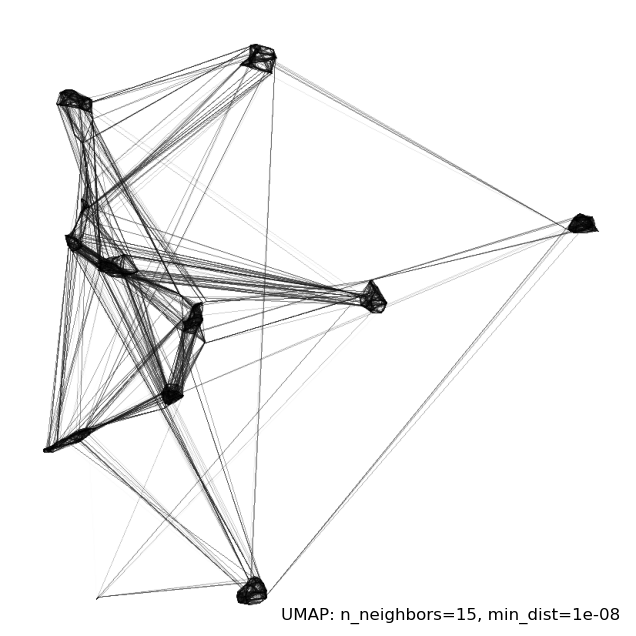

## coil

Ground truth: 
size =  21
q =  0.9494420801380001
Leiden partition: 
size =  49
q = 0.9580198216794545
-----------------------
ari = 0.741160524768101
ami = 0.8957387617027837


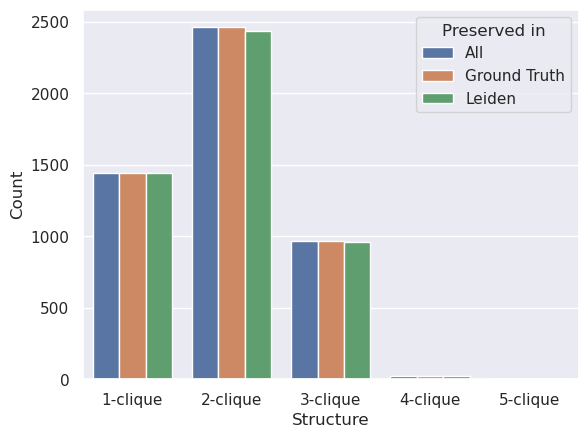

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1       10           38           72           35            0   
1              1       20           34           64           31            0   
2              2       29           25           39           16            1   
3              2       30           25           40           16            0   
4              2       33           22           36           15            0   
5              3       12           38           58           21            0   
6              3       17           34           50           17            0   
7              4        6           49           94           46            0   
8              4       32           23           43           21            0   
9              5        1           72          122           38            0   
10             6        5           67           90           22            0   
11             6       42            2            1            0            0   
12             6       43            2            1            0            0   
13             6       48            1            0            0            0   
14             7       14           37           69           33            0   
15             7       15           35           65           31            0   
16             8        9           41           78           39            1   
17             8       23           31           57           27            0   
18             9       11           38           59           10            0   
19             9       16           34           53           12            0   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             0           72          139           67            0   
1             0           72          139           67            0   
2             0           72          118           47            1   
3             0           72          118           47            1   
4             0           72          118           47            1   
5             0           72          110           38            0   
6             0           72          110           38            0   
7             0           72          140           68            0   
8             0           72          140           68            0   
9             0           72          122           38            0   
10            0           72           92           22            0   
11            0           72           92           22            0   
12            0           72           92           22            0   
13            0           72           92           22            0   
14            0           72          137           65            0   
15            0           72          137           65            0   
16            0           72          138           67            1   
17            0           72          138           67            1   
18            0           72          114           22            0   
19            0           72          114           22            0   

    5-clique_gt  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  
10            0  
11            0  
12            0  
13            0  
14            0  
15            0  
16            0  
17            0  
18            0  
19            0

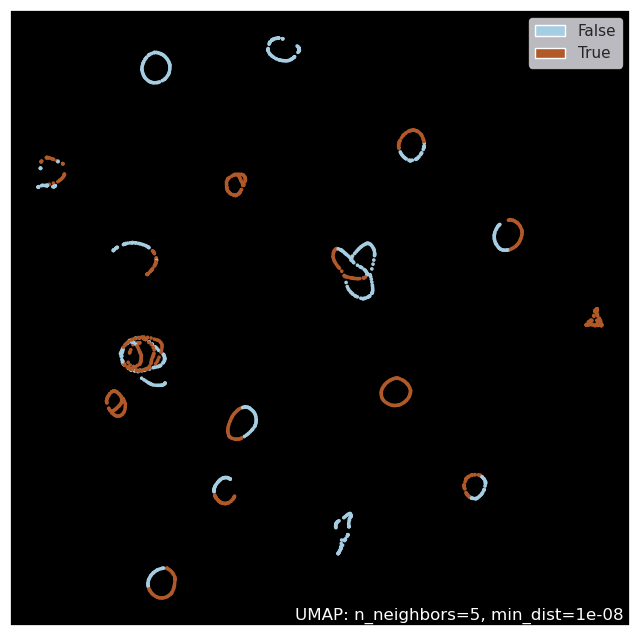

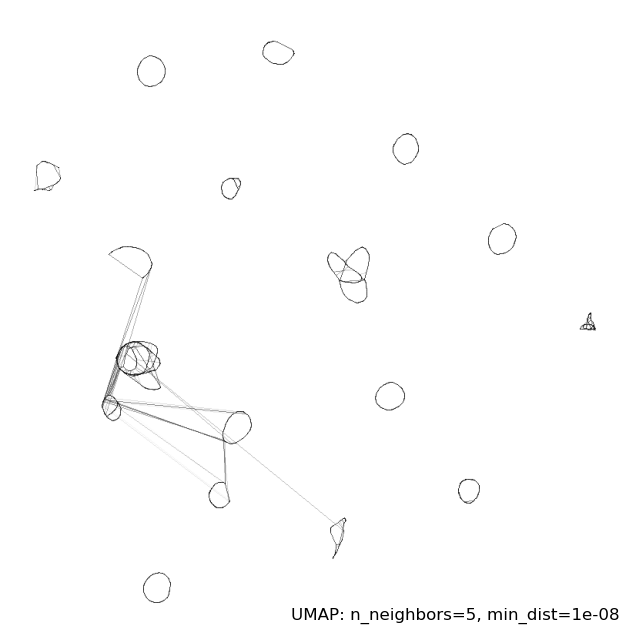

## mnist

Ground truth: 
size =  10
q =  0.8793361577356662
Leiden partition: 
size =  1968
q = 0.91502610778247
-----------------------
ari = 0.5150715866437827
ami = 0.702313724507599


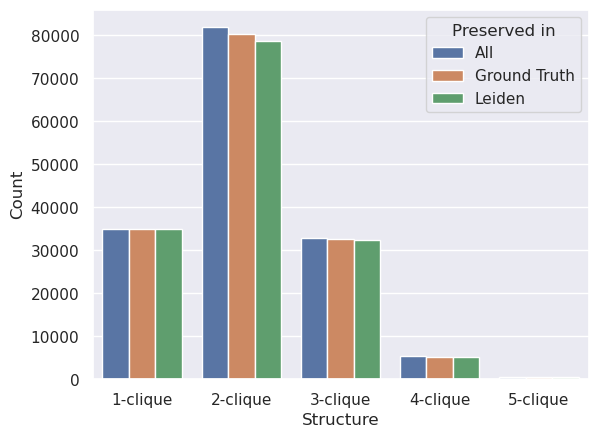

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              0        7         1634         3967         1719          259   
1              0        9         1478         3719         1581          235   
2              0       29           13           14            1            0   
3              0       31            6            7            2            0   
4              0       41            4            3            0            0   
5              0       58            3            2            0            0   
6              0       60            3            2            0            0   
7              0       68            3            2            0            0   
8              0       82            2            1            0            0   
9              0       87            2            1            0            0   
10             0       95            2            1            0            0   
11             0      111            2            1            0            0   
12             0      115            2            1            0            0   
13             0      116            2            1            0            0   
14             0      133            2            1            0            0   
15             0      139            2            1            0            0   
16             0      146            2            1            0            0   
17             0      148            2            1            0            0   
18             0      163            2            1            0            0   
19             0      166            2            1            0            0   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0            13         3434         8062         3398          505   
1            12         3434         8062         3398          505   
2             0         3434         8062         3398          505   
3             0         3434         8062         3398          505   
4             0         3434         8062         3398          505   
5             0         3434         8062         3398          505   
6             0         3434         8062         3398          505   
7             0         3434         8062         3398          505   
8             0         3434         8062         3398          505   
9             0         3434         8062         3398          505   
10            0         3434         8062         3398          505   
11            0         3434         8062         3398          505   
12            0         3434         8062         3398          505   
13            0         3434         8062         3398          505   
14            0         3434         8062         3398          505   
15            0         3434         8062         3398          505   
16            0         3434         8062         3398          505   
17            0         3434         8062         3398          505   
18            0         3434         8062         3398          505   
19            0         3434         8062         3398          505   

    5-clique_gt  
0            26  
1            26  
2            26  
3            26  
4            26  
5            26  
6            26  
7            26  
8            26  
9            26  
10           26  
11           26  
12           26  
13           26  
14           26  
15           26  
16           26  
17           26  
18           26  
19           26

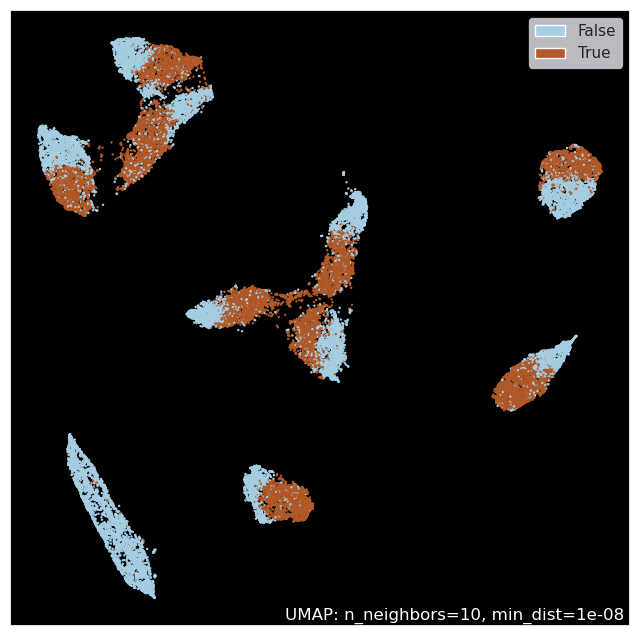

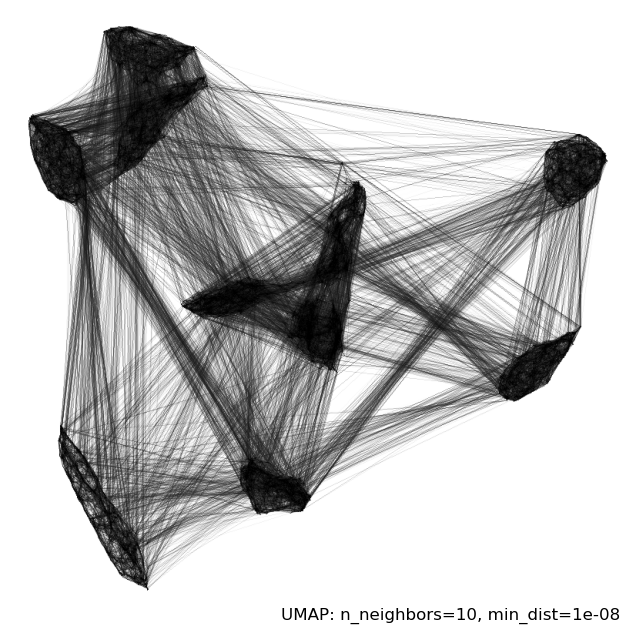

## usps

Ground truth: 
size =  11
q =  0.8757991636557155
Leiden partition: 
size =  531
q = 0.9108927935609225
-----------------------
ari = 0.5291796491211558
ami = 0.7213085891725146


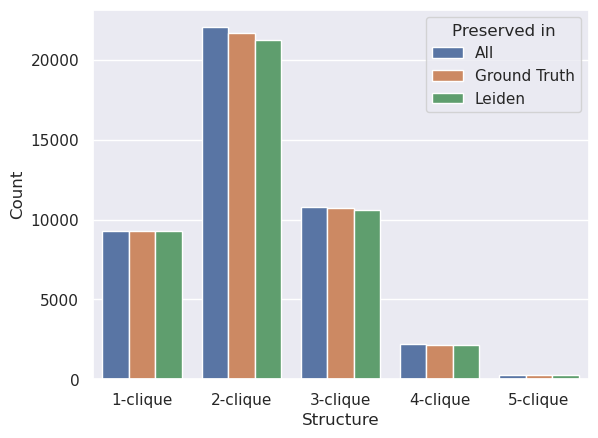

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        9          416         1021          472           82   
1              1       10          406         1035          569          113   
2              1       12          345          732          295           45   
3              1       14          254          628          371          121   
4              1       32            5            5            1            0   
5              1       33            4            4            1            0   
6              1       36            3            3            1            0   
7              1       38            3            2            0            0   
8              1       41            3            2            0            0   
9              1       48            2            1            0            0   
10             1       50            2            1            0            0   
11             1       55            2            1            0            0   
12             1       58            2            1            0            0   
13             1       61            2            1            0            0   
14             1       65            2            1            0            0   
15             1       72            2            1            0            0   
16             1       74            2            1            0            0   
17             1       76            2            1            0            0   
18             1       79            2            1            0            0   
19             1       81            2            1            0            0   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             8         1553         3613         1759          363   
1            10         1553         3613         1759          363   
2             3         1553         3613         1759          363   
3            27         1553         3613         1759          363   
4             0         1553         3613         1759          363   
5             0         1553         3613         1759          363   
6             0         1553         3613         1759          363   
7             0         1553         3613         1759          363   
8             0         1553         3613         1759          363   
9             0         1553         3613         1759          363   
10            0         1553         3613         1759          363   
11            0         1553         3613         1759          363   
12            0         1553         3613         1759          363   
13            0         1553         3613         1759          363   
14            0         1553         3613         1759          363   
15            0         1553         3613         1759          363   
16            0         1553         3613         1759          363   
17            0         1553         3613         1759          363   
18            0         1553         3613         1759          363   
19            0         1553         3613         1759          363   

    5-clique_gt  
0            48  
1            48  
2            48  
3            48  
4            48  
5            48  
6            48  
7            48  
8            48  
9            48  
10           48  
11           48  
12           48  
13           48  
14           48  
15           48  
16           48  
17           48  
18           48  
19           48

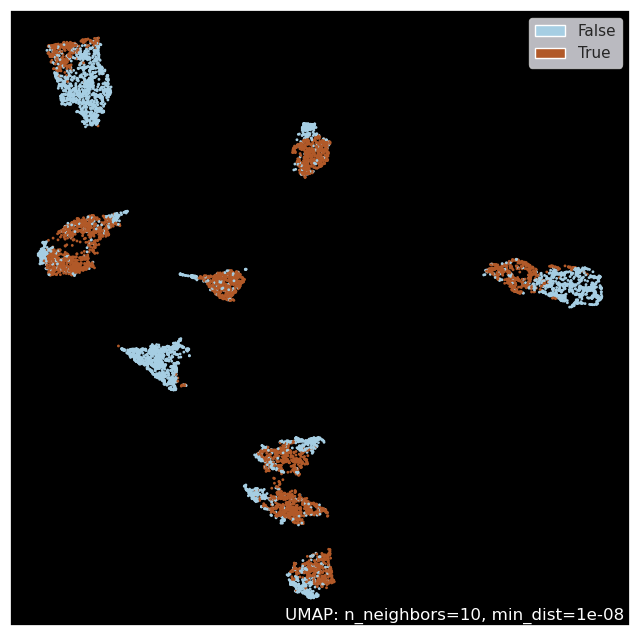

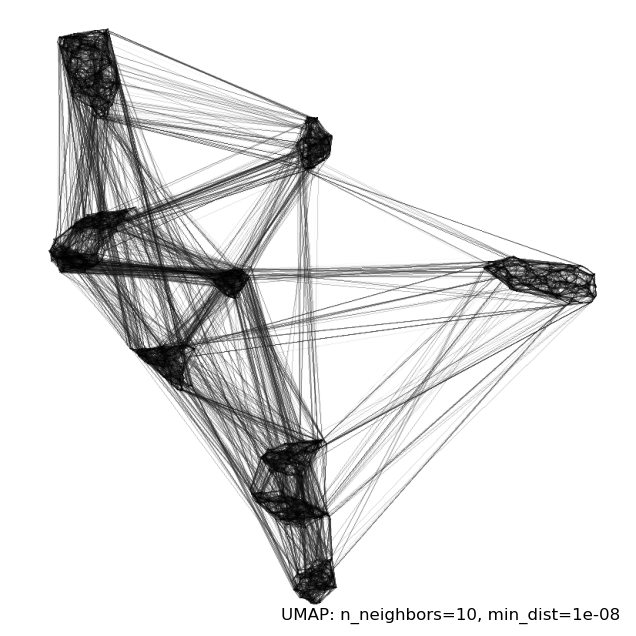

## buildings

Ground truth: 
size =  41
q =  0.947122418266131
Leiden partition: 
size =  422
q = 0.9860254260687212
-----------------------
ari = 0.36468128337432676
ami = 0.720686660639103


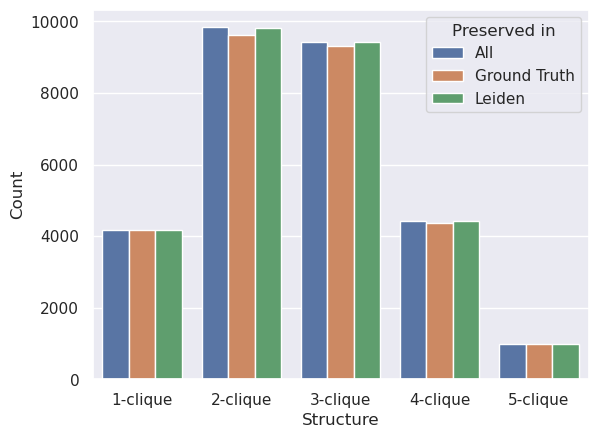

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0              1        0          100          296          226           50   
1              1        2           82          231          180           48   
2              1       19           46          108          102           57   
3              1       20           45          101           83           29   
4              1       34           36          102          117           69   
5              1       54           27           72           71           33   
6              1      122            6            8            3            0   
7              1      220            1            0            0            0   
8              1      221            1            0            0            0   
9              1      222            1            0            0            0   
10             1      223            1            0            0            0   
11             1      224            1            0            0            0   
12             1      225            1            0            0            0   
13             1      226            1            0            0            0   
14             1      227            1            0            0            0   
15             1      228            1            0            0            0   
16             1      229            1            0            0            0   
17             1      230            1            0            0            0   
18             1      231            1            0            0            0   
19             2       45           32           99          123           75   

    5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0             4          334          861          735          268   
1             2          334          861          735          268   
2            19          334          861          735          268   
3             4          334          861          735          268   
4            22          334          861          735          268   
5             8          334          861          735          268   
6             0          334          861          735          268   
7             0          334          861          735          268   
8             0          334          861          735          268   
9             0          334          861          735          268   
10            0          334          861          735          268   
11            0          334          861          735          268   
12            0          334          861          735          268   
13            0          334          861          735          268   
14            0          334          861          735          268   
15            0          334          861          735          268   
16            0          334          861          735          268   
17            0          334          861          735          268   
18            0          334          861          735          268   
19           23          112          285          312          181   

    5-clique_gt  
0            56  
1            56  
2            56  
3            56  
4            56  
5            56  
6            56  
7            56  
8            56  
9            56  
10           56  
11           56  
12           56  
13           56  
14           56  
15           56  
16           56  
17           56  
18           56  
19           53

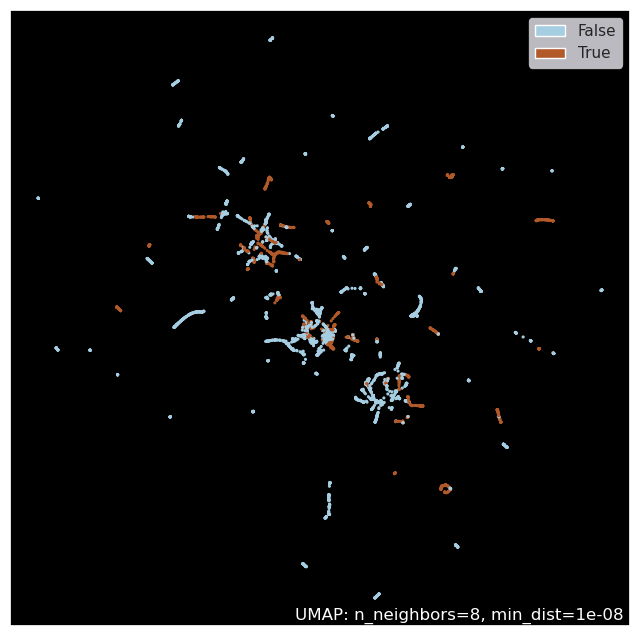

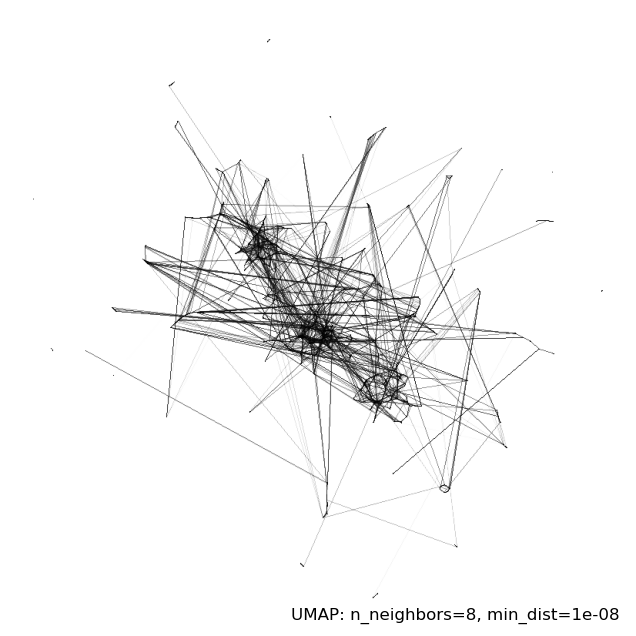

In [28]:
for dataset_id in range(5):
    G, umap_rep, clique_per_part, clique_summary, disagreement_labels = what_we_do_here(dataset_id, 0.0)
    sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
    plt.show()
    display(clique_per_part[:20])
    umap.plot.points(umap_rep, labels=disagreement_labels, color_key_cmap='Paired', background='black')
    plt.show()
    umap.plot.connectivity(umap_rep, labels=disagreement_labels, color_key_cmap='Paired')
    plt.show()

# Cliques in k-NN - low dimensional

In [17]:
def cliques_in_knn_low(dataset_id, set_op_mix_ratio, verbose=True):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    display(Markdown(f'## {dataset_name}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
    umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
    G_umap = get_umap_graph(umap_rep, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    
    ec = la.find_partition(G, la.ModularityVertexPartition)
    clustering_labels = np.array(ec.membership)
    G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')
    
    ## q-based clustering
    if(verbose):
        print('Ground truth: ')
        print('size = ', max(targets)+1)
        print('q = ',G.modularity(targets))
        print('Leiden partition: ')
        print('size = ', max(clustering_labels)+1)
        print('q =',G.modularity(ec))
        print('-----------------------')
        print('ari =',adjusted_rand_score(targets,clustering_labels))
        print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

    clique_per_part, clique_summary = clique_preservation(G_umap, targets, clustering_labels)

    return(clique_per_part, clique_summary)

## pendigits

Ground truth: 
size =  10
q =  0.8424726535927892
Leiden partition: 
size =  12
q = 0.8602168856380311
-----------------------
ari = 0.8860811639724393
ami = 0.9067286171175399


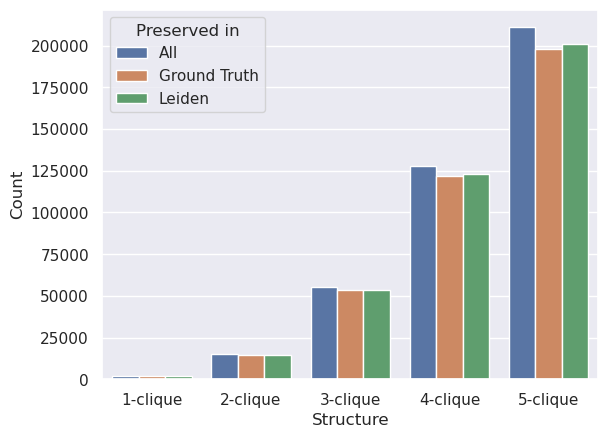

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             0        4          178         1497         5035         9937   
1             1        9          104          844         3328         8241   
2             1       10           80          633         2612         6948   
3             1       11           27          235         1118         3476   
4             2        7          167         1413         5314        12388   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0        13151          178         1497         5035         9937   
1        14485          182         1513         6047        15307   
2        13362          182         1513         6047        15307   
3         7690          182         1513         6047        15307   
4        20412          177         1458         5434        12598   

   5-clique_gt  
0        13151  
1        27649  
2        27649  
3        27649  
4        20664

## coil

Ground truth: 
size =  21
q =  0.8945446658779549
Leiden partition: 
size =  28
q = 0.9325189182410571
-----------------------
ari = 0.743189094351226
ami = 0.8752937827047246


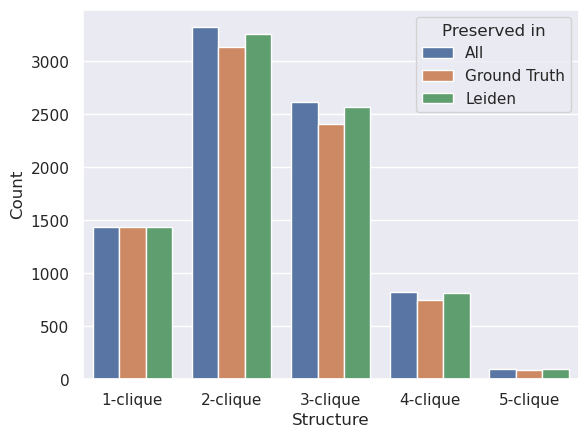

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             1        1           72          159          119           34   
1             2        9           69          156          121           35   
2             2       22           29           64           45            9   
3             3       26           19           41           29            6   
4             4        4           72          158          104           19   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0            4           72          159          119           34   
1            2           72          155          107           23   
2            0           72          155          107           23   
3            0           72          138          101           30   
4            1           72          158          104           19   

   5-clique_gt  
0            4  
1            0  
2            0  
3            3  
4            1

## mnist

Ground truth: 
size =  10
q =  0.828038492552303
Leiden partition: 
size =  13
q = 0.8582372946518656
-----------------------
ari = 0.8253552100775681
ami = 0.8507714395271939


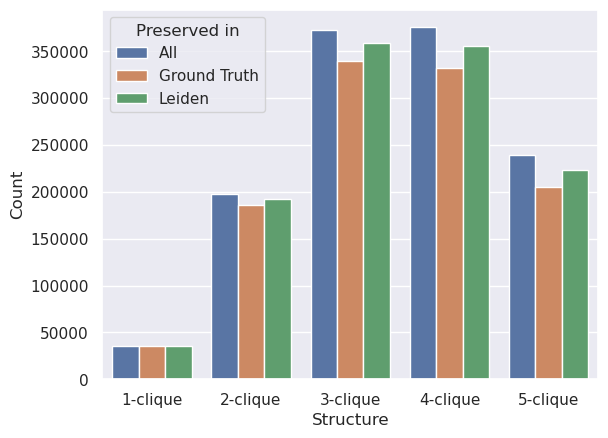

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             0        3         3496        19269        35624        34739   
1             1        8         2445        13522        27232        30660   
2             1       10         1793         9805        20520        24057   
3             2        4         3292        18314        33595        32928   
4             3        1         3555        19698        35495        33493   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0        21258         3434        18604        33798        32396   
1        22188         4002        21682        43093        47791   
2        18003         4002        21682        43093        47791   
3        20539         3434        18322        33441        32787   
4        19596         3576        18925        33910        31998   

   5-clique_gt  
0        19431  
1        33920  
2        33920  
3        20577  
4        18781

## usps

Ground truth: 
size =  11
q =  0.8283499377845813
Leiden partition: 
size =  12
q = 0.8608554411175516
-----------------------
ari = 0.8098283277522101
ami = 0.8731709436837666


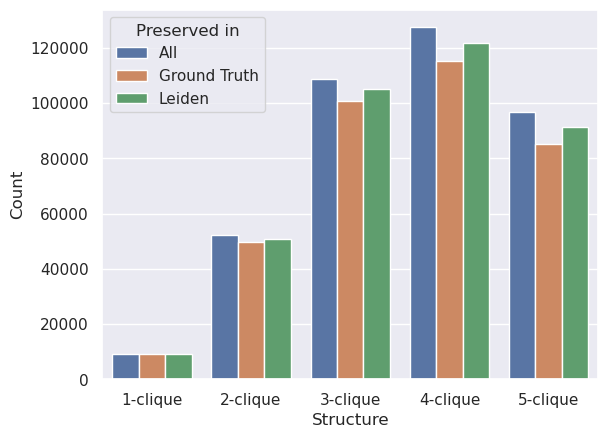

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             1        6          808         4347         8813        10037   
1             1        8          776         4172         8266         8996   
2             2        0          918         5013        10957        13775   
3             2       11          360         1916         4143         5109   
4             3        1          903         4880        10070        11723   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0         7359         1553         8422        16750        18405   
1         6214         1553         8422        16750        18405   
2        11293         1269         6912        14985        18498   
3         4084         1269         6912        14985        18498   
4         8745          929         4854        10006        11677   

   5-clique_gt  
0        12838  
1        12838  
2        14759  
3        14759  
4         8752

## buildings

Ground truth: 
size =  41
q =  0.7278299373437985
Leiden partition: 
size =  56
q = 0.8965380537932027
-----------------------
ari = 0.28626856489792146
ami = 0.6027710171008428


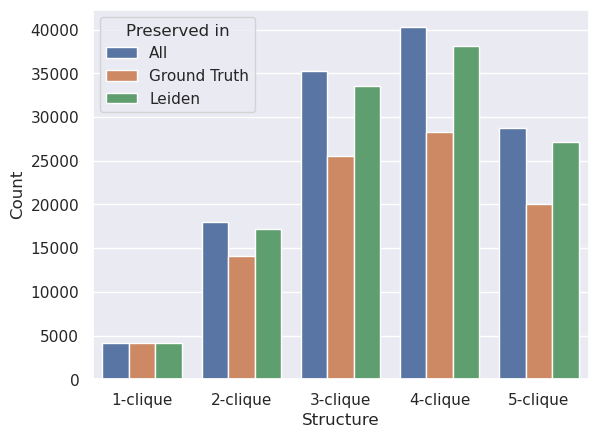

ground_truth  cluster  1-clique_cl  2-clique_cl  3-clique_cl  4-clique_cl  \
0             1        4          169          661         1142         1111   
1             1       19           82          356          631          606   
2             1       37           39          155          307          359   
3             2       21           81          341          678          786   
4             2       47           26          111          243          315   

   5-clique_cl  1-clique_gt  2-clique_gt  3-clique_gt  4-clique_gt  \
0          658          334         1135         1836         1738   
1          356          334         1135         1836         1738   
2          262          334         1135         1836         1738   
3          569          112          448          905         1098   
4          253          112          448          905         1098   

   5-clique_gt  
0         1038  
1         1038  
2         1038  
3          846  
4          846

In [37]:
for dataset_id in [0,1,2,3,4]:
    clique_per_part, clique_summary = cliques_in_knn_low(dataset_id, 1.0)
    sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
    plt.show()
    display(clique_per_part[:5])

<AxesSubplot:ylabel='Count'>

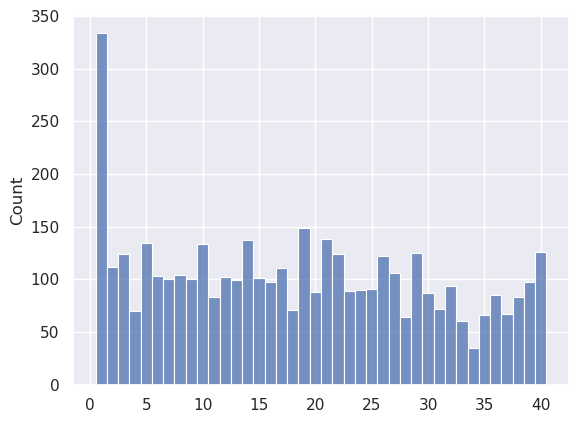

In [41]:
sns.histplot(targets, discrete=True)